# PyTorch

## Importar librerías

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Importar imágenes 

In [55]:
from get_images import get_images

In [56]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(float)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

## Normalizar imágenes

In [57]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [58]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [59]:
x_train.mean(), x_train.std()

(-9.646705203355238e-18, 0.9999999999999997)

## Mostrar imágenes 

In [60]:
x_test.shape

(10000, 784)

In [61]:
y_train.shape

(50000, 1)

In [62]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 7


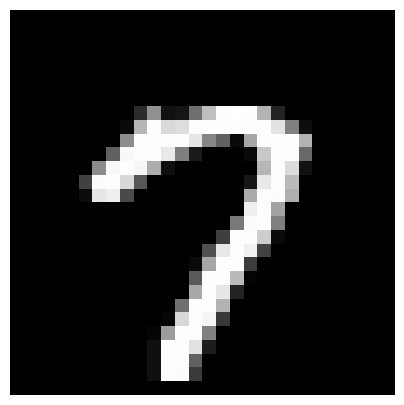

In [63]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Crear minibatches 

In [64]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Ahora sí! PyTorch

## Convertir Numpy array a PyTorch 

In [65]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())


## Usar GPU de estar disponible

In [66]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estammos usando: {device}')

Estammos usando: cpu


## Compute accuracy 

In [67]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total     
            

## Loop de entrenamiento

In [68]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        if epoch%5 == 0:    
            print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')
    

## Modelo usando Sequential

In [69]:
import random

In [83]:
#Instanciar modelo
hidden1 = 1000
hidden = 1000
epochs = 100
mb_size = 4096
models = {}
# buscar en intervalo [0.001, 1]
#for i in range(5):
    #j = -3*np.random.rand() # [0, 1]
    #lr = 10**j
    #lr = random.randrange(350, 400)/1000
lr = 0.368
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                    nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                    nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)
train(model1, optimiser, mb_size, epochs)

acc = accuracy(model1, x_val_tensor, y_val_tensor, mb_size)
print(f'con lr: {lr} accuracy:{acc}')
#print()
#models[lr] = acc    


Epoch: 0, costo: 0.8815907835960388, accuracy: 0.8154296875
Epoch: 5, costo: 0.1762980818748474, accuracy: 0.947021484375
Epoch: 10, costo: 0.14196397364139557, accuracy: 0.9619140625
Epoch: 15, costo: 0.10006093233823776, accuracy: 0.966552734375
Epoch: 20, costo: 0.07556299865245819, accuracy: 0.973876953125
Epoch: 25, costo: 0.06400316953659058, accuracy: 0.969482421875
Epoch: 30, costo: 0.03338298201560974, accuracy: 0.97509765625
Epoch: 35, costo: 0.031239161267876625, accuracy: 0.977294921875
Epoch: 40, costo: 0.03139191120862961, accuracy: 0.9755859375
Epoch: 45, costo: 0.030799157917499542, accuracy: 0.97802734375
Epoch: 50, costo: 0.01963706500828266, accuracy: 0.979736328125
Epoch: 55, costo: 0.017988143488764763, accuracy: 0.98095703125
Epoch: 60, costo: 0.013301210477948189, accuracy: 0.98193359375
Epoch: 65, costo: 0.007838033139705658, accuracy: 0.98388671875
Epoch: 70, costo: 0.00907252449542284, accuracy: 0.981201171875
Epoch: 75, costo: 0.0074753654189407825, accuracy:

In [84]:
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)

0.98193359375

In [85]:
models_ord = sorted(models.items(), key=lambda x: x[1], reverse = True)

In [86]:
models_ord

[]

## Guardar Modelo

In [74]:
model_path = './modelMNIST2.pth'

In [75]:
torch.save(
    model1.state_dict(),
    model_path)

In [76]:
model1.state_dict()['0.bias'].shape

torch.Size([100])

## Cargar Modelo

In [77]:
hidden1 = 1000 
hidden = 1000
modelMNIST = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))


In [78]:
modelMNIST

Sequential(
  (0): Linear(in_features=784, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=10, bias=True)
)

In [79]:
modelMNIST.load_state_dict(torch.load(model_path))

/tmp/ipykernel_95819/3517373775.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelMNIST.load_state_dict(torch.load(model_path))


RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 0.weight: copying a param with shape torch.Size([100, 784]) from checkpoint, the shape in current model is torch.Size([1000, 784]).
	size mismatch for 0.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for 2.weight: copying a param with shape torch.Size([100, 100]) from checkpoint, the shape in current model is torch.Size([1000, 1000]).
	size mismatch for 2.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([1000]).
	size mismatch for 4.weight: copying a param with shape torch.Size([10, 100]) from checkpoint, the shape in current model is torch.Size([10, 1000]).

In [ ]:
modelMNIST = modelMNIST.to(device = 'cuda')
modelMNIST.eval()

In [ ]:
x_test.shape[0]

In [ ]:
def sample_image():
    rnd_idx = np.random.randint(10000)
    image = x_test[rnd_idx].reshape(1, 28, 28)
    plot_number(image)
    return torch.tensor(image).to(device='cuda', dtype=torch.float).view(1, 784)
    

In [ ]:
image = sample_image()
_, pred = modelMNIST(image).max(1)
print(f'El num es: {pred[0]}')


In [ ]:
#Instanciar modelo
hidden1 = 1000 
hidden = 1000
lr = 5e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

train(model1, optimiser, mb_size, epochs)

In [ ]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)